# Collaborators Whereabouts
Author: Sam Eriksen

Description: Notebook to read in collaboration list from google sheets and plot

In [92]:
import numpy as np
import pandas as pd
#import tqdm
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance as dist
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
import io
long_cut=2500
interpolate_above=1500
short_haul_factors=pd.read_csv(io.StringIO('''
S,157.86
PLF,0.796
DC,95
CF,0.26
E_CW,1
P_CW,1
B_CW,1.5
F_CW,1.5
EF,3.16
P,0.538
M,3
AF,0.00034
A,11.68
a,0.000007
b,2.775
c,1260.608

'''), header=None)
keys=list(short_haul_factors[0])
vals=list(short_haul_factors[1])
short_haul_factors={k:vals[i] for i,k in enumerate(keys)}
long_haul_factors=pd.read_csv(io.StringIO('''
S,302.58
PLF,0.82
DC,95
CF,0.26
E_CW,1
P_CW,1.5
B_CW,4
F_CW,5
EF,3.16
P,0.538
M,3
AF,0.00034
A,11.68
a,0.00029
b,3.475
c, 3259.691

'''), header=None)
keys=list(long_haul_factors[0])
vals=list(long_haul_factors[1])
long_haul_factors={k:vals[i] for i,k in enumerate(keys)}
def calculate_emission_for_factors(factors,distance):
    #caculate kg of CO2
    x=factors['DC']+distance
    E=(factors['a']*x**2+factors['b']*x+factors['c'])/(factors['S']*factors['PLF'])
    E*=(1-factors['CF'])*factors['E_CW']*(factors['EF']*factors['M']+factors['P'])
    E+=factors['AF']*x+factors['A']
    return E
def calc_emissions_v2(distance):
    #not yet calculating layovers
    if distance>=long_cut:
        return 2*(calculate_emission_for_factors(long_haul_factors,distance))/1e3
    elif distance<=interpolate_above:
        return 2*(calculate_emission_for_factors(short_haul_factors,distance))/1e3
    else:
        short_haul_co2=calculate_emission_for_factors(short_haul_factors,distance)
        long_haul_co2=calculate_emission_for_factors(long_haul_factors,distance)
        m=(long_haul_co2-short_haul_co2)/(long_cut-interpolate_above)
        return 2*(m*(distance-interpolate_above)+short_haul_co2)/1e3

Get author list information

In [93]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "951549455"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

cut_down_df = df.loc[4:].dropna(subset=["Unnamed: 2"])

final_info = cut_down_df[["Unnamed: 47", "Unnamed: 43", "# considered (x-check)", "PRIMARY PAGE", "Unnamed: 3"]]

final_info.columns = ["Title", "Initials", "LastName", "University", "isAuthor"]

Get university address information

In [94]:
spreadsheet_id = "1J-8ehKgEcpmssEZ_dGRIp5lRQCg6tDonYYG87Rv__4I"
sheet_id = "1098381277"
sheet_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv&gid={sheet_id}"

df = pd.read_csv(sheet_url)

institutions = df[["SECONDARY PAGE", "Unnamed: 7"]]
institutions.columns = ["University", "Address"]
institutions = institutions.iloc[4:]
institutions = institutions.dropna(subset=['Address'])
institutions['Address'] = institutions['Address'].str.replace('GBR', 'UK')
institutions['Universities_FullName'] = institutions['University'] + ', ' + institutions['Address']
institutions['Short_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[-2:]))
institutions['Corrected_Name'] = institutions['University'].apply(lambda x: x.split(' (')[0])
institutions['Start_Address'] = institutions['Address'].apply(lambda x: ', '.join(x.split(', ')[:2]))

Get Long and Lat

In [95]:
def get_latitude(location):
    try:
        return location.latitude
    except AttributeError:
        return None

def get_longitude(location):
    try:
        return location.longitude
    except AttributeError:
        return None
def correct_none(entry):
    long = None
    lat = None
    print(entry['Short_Address'])
    if 'Daejeon' in entry['Short_Address']:
        lat = 36.375394
        long = 127.384520
    elif '57754-1700' in entry['Short_Address']:
        lat = 44.345992
        long = -103.755154
    print(long)
    print(lat)
    return long, lat

In [96]:
# Initialize the geocoder
geolocator = Nominatim(user_agent="university_geocoder")
# To avoid hitting the service rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [97]:
institutions['location'] = institutions['University'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Corrected_Name'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Short_Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Address'].apply(geocode)
institutions.loc[institutions['location'].isna(), 'location'] = institutions[institutions['location'].isna()]['Start_Address'].apply(geocode)

In [98]:
institutions['longitude'] = institutions['location'].apply(get_longitude)
institutions['latitude'] = institutions['location'].apply(get_latitude)
institutions[['longitude', 'latitude']] = institutions.apply(lambda row: correct_none(row) if pd.isna(row['latitude']) else (row['longitude'], row['latitude']), axis=1, result_type='expand')

Daejeon, KOR
127.38452
36.375394


Plot on a map all universities involved

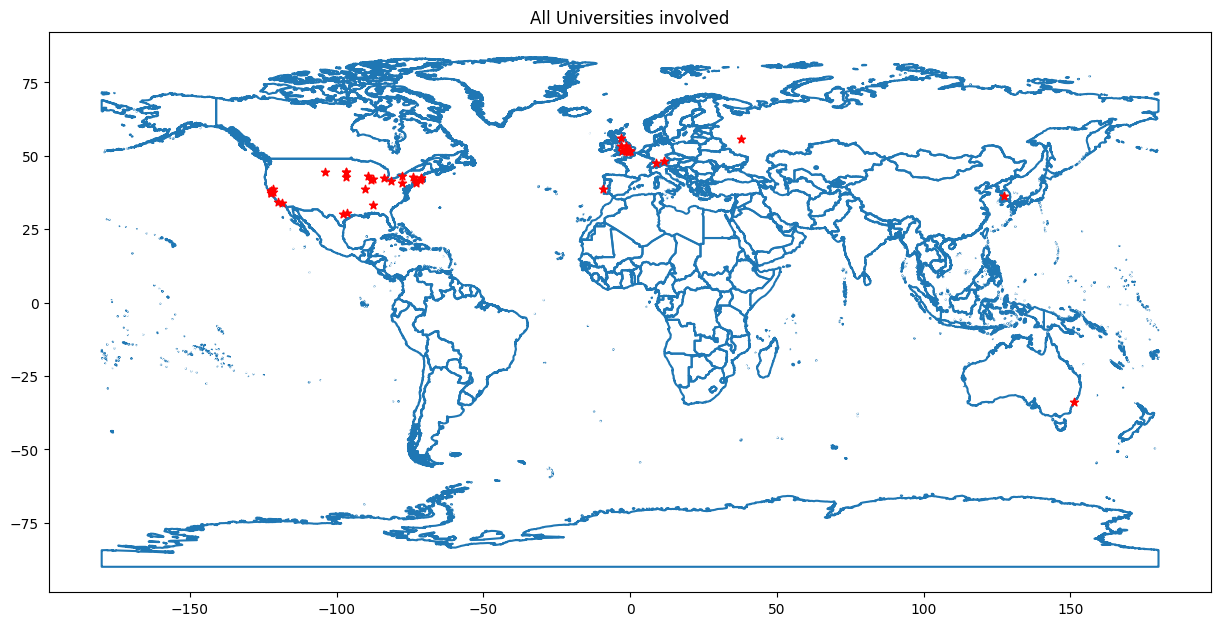

In [99]:
world = gpd.read_file('ne_10m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(institutions['longitude'],institutions['latitude'], marker='*', color='red', zorder=2)

ax.set_title('All Universities involved')
plt.show()

In [100]:
author_universities = final_info.loc[final_info['isAuthor'] == 'TRUE', 'University'].unique()
author_university_locations = institutions[institutions['University'].isin(author_universities)]

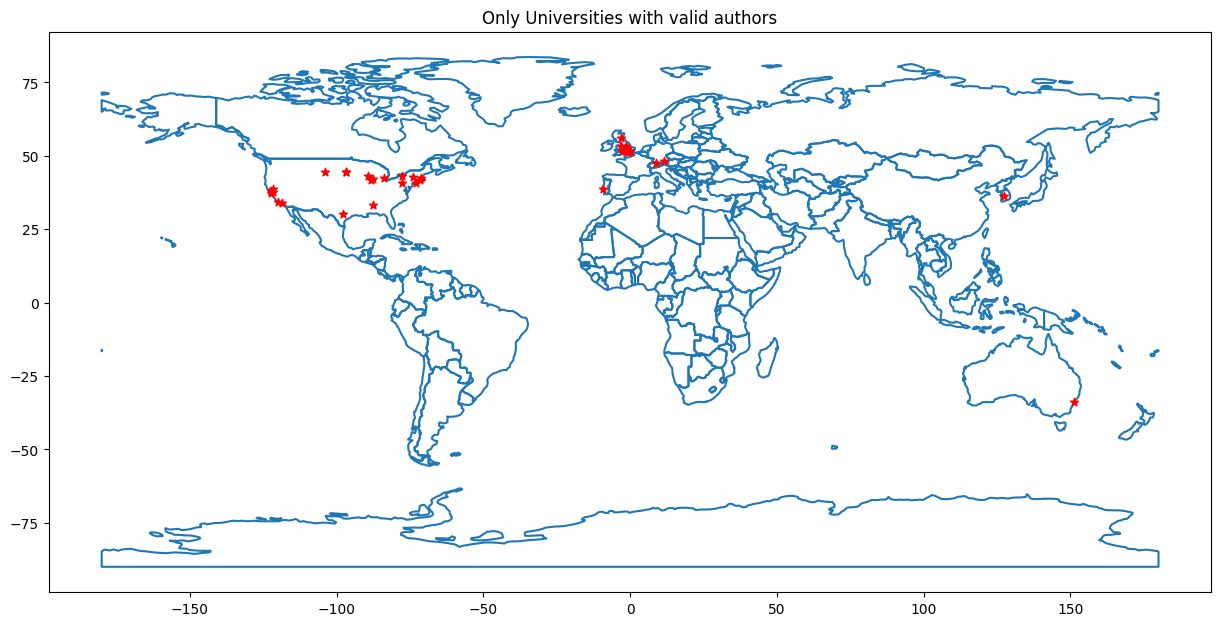

In [101]:
world = gpd.read_file('ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, zorder=1) 
ax.scatter(author_university_locations['longitude'],author_university_locations['latitude'], marker='*', color='red', zorder=2)

ax.set_title('Only Universities with valid authors')
plt.show()

Turn into density map

In [102]:
def get_country_or_state(location):
    split_loc = location.split(', ')
    if 'United States' in split_loc:
        try:
            a = int(split_loc[-2])
            binning_region = split_loc[-3]
        except:
            binning_region = split_loc[-2]
    else:
        binning_region = split_loc[-1]
        if 'Svizzera' in binning_region:
            binning_region = 'Switzerland'
    return binning_region

In [103]:
# Calculate number of authors at each university
authors = final_info.loc[final_info['isAuthor'] == 'TRUE']
author_counts = authors['University'].value_counts()
author_university_locations["author_count"] = institutions['University'].map(author_counts)

# Create binning based on either country or state
author_university_locations['Binning1'] = author_university_locations['location'].apply(lambda loc: get_country_or_state(loc.address) if loc else None)

# now recount
author_counts = authors['University'].value_counts()

# Group by 'Binning1' and sum the 'author_count', also removes None - so Korea
grouped_by_country_or_state = author_university_locations.groupby('Binning1').agg({
    'author_count': 'sum',
    'University': 'first', # To make the assumption that everyone flies from one airport in that BinningRegion
    'longitude': 'first',
    'latitude': 'first'
}).reset_index()


/tmp/ipykernel_1396865/918770465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_university_locations["author_count"] = institutions['University'].map(author_counts)
/tmp/ipykernel_1396865/918770465.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_university_locations['Binning1'] = author_university_locations['location'].apply(lambda loc: get_country_or_state(loc.address) if loc else None)


In [104]:
row_index = author_university_locations.loc[author_university_locations['University'] == 'University of Maryland'].index[0]
author_university_locations.loc[row_index,'latitude']=38.971500
author_university_locations.loc[row_index,'longitude']=-76.940308
# author_university_locations.loc[author_university_locations['University'] == 'University of Maryland']

In [105]:

def cross_distances(data):
    cumulative_distance=[]
    for index,institute in data.iterrows():
        total_distance=0
        for other_index,other_institute in data.iterrows():
            if index==other_index:
                continue
            total_distance+=other_institute['author_count']*calc_emissions_v2(dist.distance(
                                         (institute['latitude'],institute['longitude']),
                                         (other_institute['latitude'],other_institute['longitude'])).km)

        cumulative_distance.append(total_distance)

    return data.assign(cumulative_distance=cumulative_distance)
def plot_sites(author_dists):
    longs=np.array(author_dists.sort_values(by=['cumulative_distance'])['longitude'])
    lats=np.array(author_dists.sort_values(by=['cumulative_distance'])['latitude'])


    world = gpd.read_file('ne_110m_admin_0_countries.shp')
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    carbon_map = matplotlib.colormaps['summer']
    world.boundary.plot(ax=ax, zorder=1) 
    max_marker=150
    min_marker=50

    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker='*', color=color,s=100)

    cmap = carbon_map
    min_dist=max(author_dists['cumulative_distance'])#*100/341 #*2*150/1e6*100
    max_dist=min(author_dists['cumulative_distance'])#*100/341 #*2*150/1e6*100
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')
    clb.set_label('tCO2e for every Author',fontsize=18)
    plt.xlim([-140,155])
    plt.ylim([-40,60])
    plt.xlabel("longitude ($^\circ$)",fontsize=18)
    plt.ylabel("latitude ($^\circ$)",fontsize=18)
    clb.ax.tick_params(labelsize='large')

                     University  \
38      University of Rochester   
24  University at Albany (SUNY)   
36       University of Michigan   

                                              Address  \
38  Department of Physics and Astronomy, Rochester...   
24  Department of Physics, 1400 Washington Avenue,...   
36  Randall Laboratory of Physics, 450 Church Stre...   

                                Universities_FullName       Short_Address  \
38  University of Rochester, Department of Physics...  NY 14627-0171, USA   
24  University at Albany (SUNY), Department of Phy...  NY 12222-1000, USA   
36  University of Michigan, Randall Laboratory of ...  MI 48109-1040, USA   

             Corrected_Name                                     Start_Address  \
38  University of Rochester    Department of Physics and Astronomy, Rochester   
24     University at Albany     Department of Physics, 1400 Washington Avenue   
36   University of Michigan  Randall Laboratory of Physics, 450 Church Street 

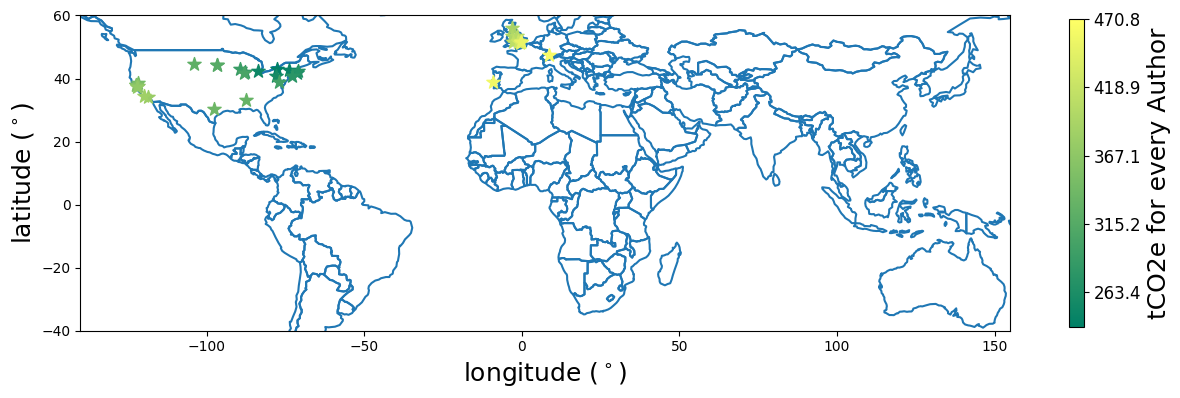

In [111]:

cut=author_university_locations['longitude']<100
author_dists=cross_distances(author_university_locations[cut])
plot_sites(author_dists)
print(author_dists.sort_values(by=['cumulative_distance'])[:3])
print(author_dists.sort_values(by=['cumulative_distance'])[-3:])

West Coast
                                      University  \
13  Lawrence Berkeley National Laboratory (LBNL)   
19          SLAC National Accelerator Laboratory   
28            University of California, Berkeley   

                                              Address  \
13     1 Cyclotron Road, Berkeley, CA 94720-8099, USA   
19  2575 Sand Hill Road, Menlo Park, CA 94205-7015...   
28  Department of Physics, 366 LeConte Hall MC 730...   

                                Universities_FullName       Short_Address  \
13  Lawrence Berkeley National Laboratory (LBNL), ...  CA 94720-8099, USA   
19  SLAC National Accelerator Laboratory, 2575 San...  CA 94205-7015, USA   
28  University of California, Berkeley, Department...  CA 94720-7300, USA   

                           Corrected_Name  \
13  Lawrence Berkeley National Laboratory   
19   SLAC National Accelerator Laboratory   
28     University of California, Berkeley   

                                      Start_Address  \
13    

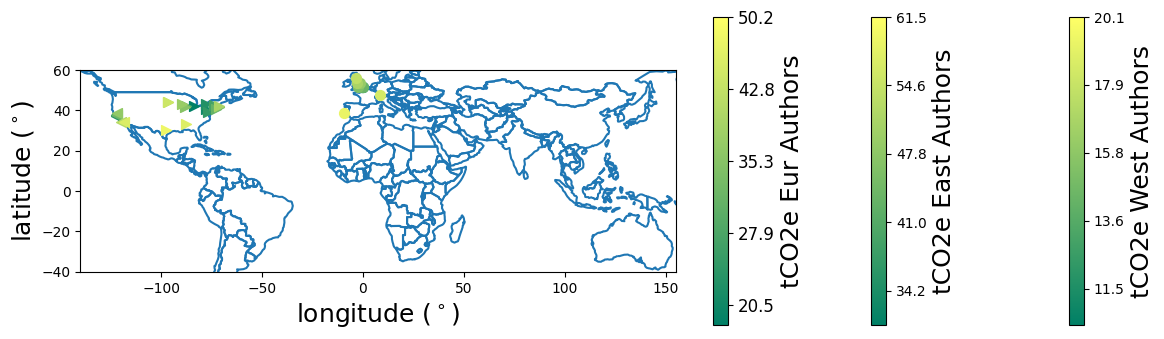

In [85]:
print("West Coast")
west_coast_cut=(author_university_locations['longitude']<-110)#|(author_university_locations['longitude']>110)
west_author_dists=cross_distances(author_university_locations[west_coast_cut])

print(west_author_dists.sort_values(by=['cumulative_distance'])[:3])



east_coast_cut=(author_university_locations['longitude']>-100)&(author_university_locations['longitude']<-25)
east_author_dists=cross_distances(author_university_locations[east_coast_cut])

print("East Coast")
print(east_author_dists.sort_values(by=['cumulative_distance'])[:3])


europe=(author_university_locations['longitude']>-25)&(author_university_locations['longitude']<110)
europe_author_dists=cross_distances(author_university_locations[europe])

print("Europe")
print(europe_author_dists.sort_values(by=['cumulative_distance'])[:3])





world = gpd.read_file('ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
carbon_map = matplotlib.colormaps['summer']
world.boundary.plot(ax=ax, zorder=1) 

markers=['<','>','o']
labels=['West','East','Eur']
for j,author_dists in enumerate([west_author_dists,east_author_dists,europe_author_dists]):
    longs=np.array(author_dists.sort_values(by=['cumulative_distance'])['longitude'])
    lats=np.array(author_dists.sort_values(by=['cumulative_distance'])['latitude'])
    for i,(long,lat) in enumerate(np.transpose([longs,lats])):
        color=carbon_map(i/len(longs))
        ax.scatter(long,lat, marker=markers[j], color=color,s=50)

    cmap = carbon_map
    min_dist=max(author_dists['cumulative_distance'])
    max_dist=min(author_dists['cumulative_distance'])
    norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

    clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
                 label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
                format='%.1f')
    clb.set_label(f'tCO2e {labels[j]} Authors',fontsize=18)
plt.xlim([-140,155])
plt.ylim([-40,60])
plt.xlabel("longitude ($^\circ$)",fontsize=18)
plt.ylabel("latitude ($^\circ$)",fontsize=18)
clb.ax.tick_params(labelsize='large')

In [78]:
west_coast_cut=(author_university_locations['longitude']<-110)#|(author_university_locations['longitude']>110)
west_author_dists=cross_distances(author_university_locations[west_coast_cut])

print(west_author_dists.sort_values(by=['cumulative_distance'])[:3])

(4     False
 5     False
 7     False
 8     False
 9     False
 10    False
 12    False
 13     True
 14     True
 16    False
 17    False
 18    False
 19     True
 20    False
 21    False
 22    False
 24    False
 25    False
 26    False
 27    False
 28     True
 29     True
 30     True
 31     True
 32    False
 33    False
 34    False
 35    False
 36    False
 37    False
 38    False
 39    False
 41    False
 47    False
 48    False
 49    False
 50    False
 Name: longitude, dtype: bool,
 0)

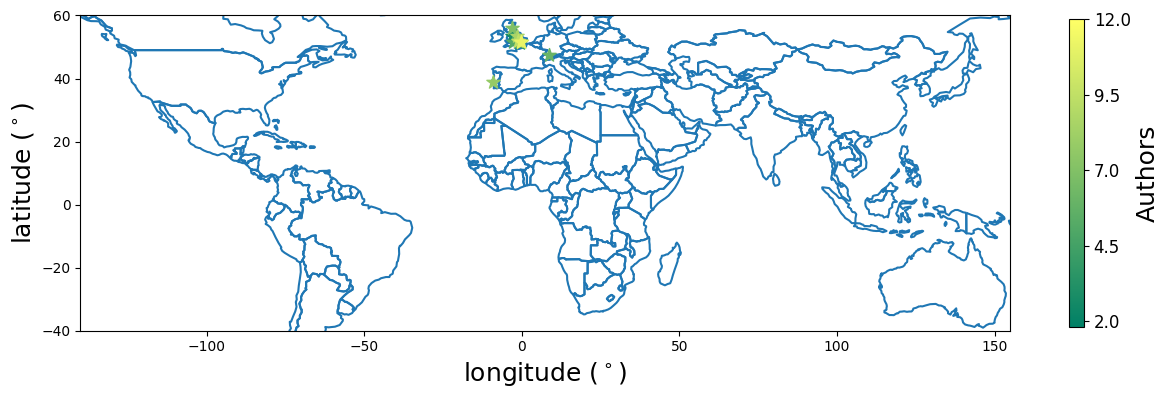

In [86]:
import matplotlib
longs=np.array(author_dists.sort_values(by=['author_count'])['longitude'])
lats=np.array(author_dists.sort_values(by=['author_count'])['latitude'])
author_count=np.array(author_dists['author_count'])

world = gpd.read_file('ne_110m_admin_0_countries.shp')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
carbon_map = matplotlib.colormaps['summer']
world.boundary.plot(ax=ax, zorder=1) 
max_marker=150
min_marker=50

for i,(long,lat) in enumerate(np.transpose([longs,lats])):
    color=carbon_map(i/len(longs))
    ax.scatter(long,lat, marker='*', color=color,s=100)
    
cmap = carbon_map
min_dist=max(author_count)
max_dist=min(author_count)
norm = matplotlib.colors.Normalize(vmin=min_dist, vmax=max_dist)

clb=plt.colorbar(matplotlib.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
             label='tCO2e of flights',ticks=np.linspace(min_dist,max_dist,5,endpoint=True),
            format='%.1f')
clb.set_label('Authors',fontsize=18)
plt.xlim([-140,155])
plt.ylim([-40,60])
plt.xlabel("longitude ($^\circ$)",fontsize=18)
plt.ylabel("latitude ($^\circ$)",fontsize=18)
clb.ax.tick_params(labelsize='large')


In [71]:
markersize

107.29729729729729

In [24]:
# Load your GeoDataFrames
world = gpd.read_file('ne_110m_admin_0_countries.shp')
us_states = gpd.read_file('tl_2023_us_state.shp')

# Add country data
all_countries = world[['SOVEREIGNT', 'geometry']]
all_countries = all_countries.merge(grouped_by_country_or_state, how='left', left_on='SOVEREIGNT', right_on='Binning1')
all_countries['author_count'] = all_countries['author_count'].fillna(0)

# us states
states = us_states[['NAME', 'geometry']]
states = states.merge(grouped_by_country_or_state, how='left', left_on='NAME', right_on='Binning1')

# Define a colormap where the lowest value (0) is white and the rest are colored
cmap = plt.get_cmap('viridis')
cmap = mcolors.ListedColormap(['white'] + [cmap(i) for i in range(cmap.N)])

# Normalize data to ensure non-zero values pop more
norm = mcolors.Normalize(vmin=0, vmax=states['author_count'].max())

fig, ax = plt.subplots(1, 1, figsize=(30, 20))
world.boundary.plot(ax=ax, color='black')
us_states.boundary.plot(ax=ax, color='black')

# Plot the world map with the colormap
all_countries.plot(column='author_count', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)
states.plot(column='author_count', cmap=cmap, norm=norm, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add a legend with a distinct color map
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Author Density', fontsize=20)


plt.show()

KeyError: "['SOVEREIGNT'] not in index"

Find the nearest three airport

In [ ]:
import airportsdata
from geopy.distance import great_circle

airports = airportsdata.load('IATA')
airports_df = pd.DataFrame.from_dict(airports, orient='index')

def find_nearest_airports(lat, lon, top_n=3): # assume one of the top 3 is a 'proper airport'
    # Calculate distances and add them as a new column
    airports_df['distance'] = airports_df.apply(
        lambda row: great_circle((lat, lon), (row['lat'], row['lon'])).km,
        axis=1
    )
    
    # Sort the DataFrame by distance
    sorted_airports_df = airports_df.sort_values(by='distance')
    
    # Select the top N nearest airports
    nearest_airports = sorted_airports_df.head(top_n)
    
    return nearest_airports[['iata', 'distance']].values.tolist()

def get_nearest_airports(row):
    return find_nearest_airports(row['latitude'], row['longitude'])

author_aiports_df = grouped_by_country_or_state
author_aiports_df['Airports'] = author_aiports_df.apply(get_nearest_airports, axis=1)

In [ ]:
author_aiports_df

In [ ]:
import requests

def check_direct_flights(airport_code1, airport_code2, api_key):
    url = f'http://api.aviationstack.com/v1/flights?access_key={api_key}&dep_iata={airport_code1}&arr_iata={airport_code2}'
    response = requests.get(url)
    data = response.json()
    # Check if any flights are found
    if 'data' in data and len(data['data']) > 0:
        return True
    return False

api_key = 'API-KEY'
airport_code1 = 'LHR'
airport_code2 = 'BOS'

has_direct_flights = check_direct_flights(airport_code1, airport_code2, api_key)
print(f"Direct flights from {airport_code1} to {airport_code2}: {'Yes' if has_direct_flights else 'No'}")